In [454]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
from importlib import reload
import cv2
import json
from pathlib import Path

print('Python | Pytorch | OpenCV versions: %s | %s | %s' %(sys.version, torch.__version__, cv2.__version__))

sys.path.append('/home/blanca/mnt/projects/')
import tools
from tools.utils import *
from tools.visuals import *

if __name__ == "__main__":
    print("lol")

Python | Pytorch | OpenCV versions: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0] | 0.4.1 | 3.4.3
lol


In [465]:
xml_annotations_folder_path = '__toy_plane/Annotations_folders'
xml_annotations_folder_path = Path(xml_annotations_folder_path)

ann_files = []
# for xml_annotations_path in xml_annotations_folder_path.glob('*'):
# #     if xml_annotations_path.name == 'annotations_2':
# #         print(len(list(xml_annotations_path.glob("*.xml"))))
#         folder_files = np.array(list(xml_annotations_path.glob("*.xml")))
#         ann_files.append(folder_files)

xml_annotations_paths = [
    '__toy_plane/9009_task_2',
#     '__toy_plane/9009_task_3',
]

for xml_annotations_path in xml_annotations_paths:
    path = Path(xml_annotations_path)
    print(len(list(path.glob("*.xml"))))
    ann_files.append(np.array(list(path.glob("*.xml"))))

ann_files = np.concatenate(ann_files, axis=0)
len(ann_files)

741


741

In [466]:
screened_images_path = Path('/home/blanca/mnt/data/__toy_plane/JPEGImages_9009_task_2_screened')
screened_images = list(screened_images_path.glob("*.jpg"))
screened_images_names = [i.name.split('.jpg')[0] for i in screened_images]
len(screened_images_names)

576

In [467]:
path = xml_annotations_folder_path
cat_file = path.parent / Path('toy_plane_classes_attbs_body_drill.names') # 11 classes

with open(str(cat_file), 'r') as f:
    cat_data = [i.strip() for i in f.readlines()]

cat_data = [i.lower() for i in cat_data]
cat_dic = {i:cat_data[i] for i in range(len(cat_data))}
cat_dic

{0: 'body',
 1: 'carriage',
 2: 'cockpit',
 3: 'drill',
 4: 'hand',
 5: 'hex drill tip',
 6: 'large wheel',
 7: 'wheel disk',
 8: 'wing 1',
 9: 'wing 2',
 10: 'propeller',
 11: 'screw',
 12: 'small wheel',
 13: 'star drill tip',
 14: 'has wing 1',
 15: 'has wing 2',
 16: 'has small wheels',
 17: 'has propeller',
 18: 'has cockpit',
 19: 'has carriage',
 20: 'has drill tip',
 21: 'has hex drill tip',
 22: 'button pressed'}

In [468]:
class_names = [
    'Body',
    'Carriage',
    'Cockpit',
    'Drill',
    'Hand',
    'Hex Drill Tip',
    'Large Wheel',
    'Wheel Disk',
    'Wing 1',
    'Wing 2',
    'Propeller',
    'Screw',
    'Small Wheel',
    'Star Drill Tip'
]
attbs_names = [
    'Has wing 1', 
    'Has wing 2', 
    'Has small wheels', 
    'Has propeller', 
    'Has cockpit', 
    'Has carriage',
    'Has drill tip', 
    'Has hex drill tip',
    'Button pressed', 
]

class_names = [i.lower() for i in class_names]
attbs_names = [i.lower() for i in attbs_names]

In [469]:
import os, sys
import xmltodict
from pathlib import Path
import numpy as np
from skimage import io
import operator
from functools import reduce
import collections
# url
import xmltodict
from skimage import io
import urllib
import random

from PIL import Image
import torchvision

def xy_xy2ulxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = x[0]
    y[1] = x[1]
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()

def xy_xy2bbxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = (x[0] + x[2]) / 2
    y[1] = (x[1] + x[3]) / 2
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()
     
def adjust_polygon_format(o_polygon):
    polygon_list = []
    co_k_x = [i for i in list(o_polygon.keys()) if i[0] == 'x']
    co_k_x = sorted(co_k_x, key=lambda x: int(x[1:]))
    for i in co_k_x:
        ix = i[1:]
        xk, yk = i, 'y' + ix
        polygon_list.append([float(o_polygon[xk]), float(o_polygon[yk])])
        
    polygon_list = reduce(operator.add, polygon_list)
    
    return polygon_list

def download_image_from_imo(imo, output_path, save_images=True, apply_transforms=False): 
    
        iid, url = imo['id'], imo['coco_url']
        try: im = np.asarray(bytearray(urllib.request.urlopen(url).read()))
        except: 
            print('not_fetched') 
        im = cv2.imdecode(im, -1)
        
        im_name = imo['file_name'] #.split('.png')[0] + '.jpg'
        if save_images: 
            cv2.imwrite(output_path + im_name, im)
            # print(im.dtype) uint16
            im = cv2.imread(output_path + im_name)
            # print(im.dtype)uintn8
        return im
    
def save_image(im, imo, output_path, save_images=True, apply_transforms=False): 
        
        im_name = imo['file_name'] #.split('.png')[0] + '.jpg'
        if save_images: cv2.imwrite(output_path + im_name, im)
        
        return im

In [470]:
def apply_transform_im(im, seed, v_flip=0.5, h_flip=0.5):
    """
    Args:
    -img : Numpy Array in RGB. 
    -bbx : bounding box of object as list or tuple [xmin, ymin, xmax or width, ymax or height]
            Should be integers associated with the image input size
    -v_flip : chance of a vertical flip
    -h_flip : chance of a horizontal flip
    Return:
    -img : Transformed img as numpy array in RGB
    -bbx : 
    """
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)# .astype(np.uint8)
#     im = Image.fromarray(im)

    im = Image.fromarray(im.astype(np.uint8))
    
    hori_flip = torchvision.transforms.RandomHorizontalFlip(p=1)
    vert_flip = torchvision.transforms.RandomVerticalFlip(p=1)
    jitter = torchvision.transforms.ColorJitter(brightness=.6,contrast=.6,saturation=0.6,hue=0)

    im = jitter(im)
    
    random.seed(seed)
    if random.random() < v_flip:
        im = vert_flip(im)

    random.seed(seed)
    if random.random() < h_flip:
        im = hori_flip(im)
        
#     im = np.array(im)
#     im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) #.astype(np.float32)
    
    im = np.array(im)
    return im
    
def apply_transform_bbox(bbx, im_shape, seed, box_conv='hw', v_flip=0.5, h_flip=0.5):
    """
    Args:
    -img : Numpy Array in RGB. 
    -bbx : bounding box of object as list or tuple [xmin, ymin, xmax or width, ymax or height]
            Should be integers associated with the image input size
    -v_flip : chance of a vertical flip
    -h_flip : chance of a horizontal flip
    Return:
    -img : Transformed img as numpy array in RGB
    -bbx : 
    """

    xmin = bbx[0]
    ymin = bbx[1]
    if box_conv == 'hw':
        xmax = xmin + bbx[2]
        ymax = ymin + bbx[3]
    else:
        xmax = bbx[2]
        ymax = bbx[3]
        
    h, w, c = im_shape
    
    hori_flip = torchvision.transforms.RandomHorizontalFlip(p=1)
    vert_flip = torchvision.transforms.RandomVerticalFlip(p=1)
    jitter = torchvision.transforms.ColorJitter(brightness=.6,contrast=.6,saturation=0.6,hue=0)
    
    random.seed(seed)
    if random.random() < v_flip:
        ymin, ymax = (h - ymax, h - ymin)

    random.seed(seed)
    if random.random() < h_flip:
        xmin, xmax = (w - xmax , w - xmin)

    if box_conv == 'hw':
        return [xmin,ymin,xmax-xmin,ymax-ymin]
    else:
        return [xmin,ymin,xmax,ymax]

In [471]:
attbs_names_dic = [
    "Has wing 1", 
    "Has wing 2", 
    "Has small wheels", 
    "Has propeller", 
    "Has cockpit", 
    "Has carriage"
]

default_attbs_dic = { # contains the folder name as key and a list of the missing attributes as the value
 'annotations_10' : [True, True, True, True, False, True],
 'annotations_11' : [True, True, False, False, True, True],
 'annotations_12' : [True, True, False, True, True, True],
 'annotations_13' : [True, True, True, True, True, False],
 'annotations_14' : [True, True, True, False, True, True],
 'annotations_2' : [True, True, True, True, True, True],
 'annotations_3' : [False, True, True, False, True, False],
 'annotations_4' : [True, False, True, True, True, True],
 'annotations_5' : [True, False, True, True, False, True],
 'annotations_6' : [True, False, True, True, True, False],
 'annotations_7' : [False, False, True, True, False, True],
 'annotations_8' : [False, True, True, True, True, True],
 'annotations_9' : [False, False, False, True, False, False]
}

In [472]:
def create_mcnn_dataset(ann_files, cat_file, out_dir, default_attbs_dic=default_attbs_dic, augmentation=False):

    with open(str(cat_file), 'r') as f:
        cat_data = [i.strip() for i in f.readlines()]
        cat_data = [i.lower() for i in cat_data]

    cat_dic = {i:cat_data[i] for i in range(len(cat_data))}

    ### CATEGORIES ###

    categories = [{
        "id" : i, #int, 
        "name" : j, #str, 
        "supercategory" : j, #str,
    } for i, j in cat_dic.items()]

    ### DATASET ###

    info = {
        "year" : '2018', 
        "version" : '1', 
        "description" : 'fumehood', 
        "contributor" : 'v7', 
        "url" : 'none', 
        "date_created" : '2018/09/20',
    }

    dataset = {

        "info" : info, 
        "images" : [],       # image
        "annotations" : [],  # annotation
        "licenses" : [],     # license
        "categories": categories
    }

    count_i = 0
    count_o = 0
    total_dv_files = 0
    
    obss_wo_atts = 0
    obss_w1_atts = 0
    obss_ws_atts = 0
    
    default_anns = 0
    count_not_anno = 0
    
    for file in ann_files:
        
        seed = random.randint(0, 1000)
        
        task = file.parent.name
        
        if task not in default_attbs_dic: augmentation == False
        default_attbs = None
        if task in list(default_attbs_dic.keys()):
            default_attbs = default_attbs_dic[task]
            default_attbs = [attbs_names[i] for i in range(len(default_attbs)) if default_attbs[i] == True]
        
        with open(str(file)) as fd:
            try: doc = xmltodict.parse(fd.read())
            except: print(file); continue
            
            # creating an image: 
            data = doc['annotation']
            # image
            folder = data['folder']
            filename = data['filename']        
            session_type = folder.split('/')[-2]
            session = folder.split('/')[-1]
            im_name = '{:06d}'.format(int(filename.split('.png')[0]))
            im_name = '%s_%s_%s.png' %(session_type, session, im_name)
            if not default_attbs: 
                if im_name.split('.png')[0] in screened_images_names:
                    pre = task[:4]
                    im_name = pre + '_' + im_name  
                else: continue
                
            url = folder + '/' + filename
            
            try:
                width = int(data['size']['width'])
                height = int(data['size']['height'])
            except: count_not_anno +=1; continue
            try:
                objects = data['object']
            except: count_not_anno +=1; continue
            
            count_i += 1
            image_dic = {
                "id" : count_i, #int, 
                "width" : width, #int, 
                "height" : height, #int, 
                "file_name" : im_name, #str, 
                "license" : 0, #int, 
                "flickr_url" : 'no-flickr_url', #str, 
                "coco_url" : url, #str, 
                "date_captured" : "2018-20-01 00:00:00", #datetime,
            }

            license = {
                "id" : count_i, #int, 
                "name" : im_name, #str, 
                "url" : 'url', #str,
            }

            dataset['images'].append(image_dic)
            dataset['licenses'].append(image_dic)
            im = download_image_from_imo(image_dic, out_dir)
            
            if augmentation:
                
                im_name_aug = 'a_' + im_name
                
                count_i += 1
                image_dic_aug = {
                    "id" : count_i, #int, 
                    "width" : width, #int, 
                    "height" : height, #int, 
                    "file_name" : im_name_aug, #str, 
                    "license" : 0, #int, 
                    "flickr_url" : 'no-flickr_url', #str, 
                    "coco_url" : url, #str, 
                    "date_captured" : "2018-20-01 00:00:00", #datetime,
                }

                dataset['images'].append(image_dic_aug)
                
                im_aug = apply_transform_im(im, seed)
                save_image(im_aug, image_dic_aug, out_dir)
            
            # parsing objects annotations
            if isinstance(objects, dict): objects = [objects]
        
            for i in objects:

                o_cat_name = i['name'].lower()
                if o_cat_name not in class_names: 
                    continue
                o_cat_ix = cat_data.index(o_cat_name)
                o_polygon = [[]]
#                 o_polygon = i['polygon']
#                 o_polygon = [adjust_polygon_format(o_polygon)]
                o_bbox = [i['bndbox']['xmin'], i['bndbox']['ymin'], i['bndbox']['xmax'], i['bndbox']['ymax']]
                o_bbox = xy_xy2ulxy_wh([int(i) for i in o_bbox])
                try: o_dv_angle = i['direction']['angle']; total_dv_files += 1
                except: o_dv_angle = None 
                
                attbs = [o_cat_ix]
                count_true_attbs = 0
                for i, j in i['attributes'].items(): # i(attribute), j(list of Odicts or Odict)
                    if isinstance(j, collections.OrderedDict): j = [j]
                    for ODict in j: 
                        attb_name = ODict['@name'].lower()
                        if ODict['#text'] == 'true' and attb_name in attbs_names: 
                            attbs.append(cat_data.index(attb_name))
                            count_true_attbs += 1
                
                # overwrite to defaults if they all false
                if o_cat_name == 'body' and count_true_attbs == 0:
                    if default_attbs: 
                        assert default_attbs is not None
                        default_anns +=1 
                        [attbs.append(cat_data.index(i)) for i in default_attbs]                
                        
                if len(attbs) == 1: obss_wo_atts += 1
                elif len(attbs) == 2: obss_w1_atts += 1
                elif len(attbs) > 2: obss_ws_atts += 1
                
                count_o += 1
                
                if augmentation: count_i -= 1
                annotation = {
                    "id" : count_o, #int, 
                    "image_id" : count_i, #int, 
                    "category_id" : attbs, # o_cat_ix, # attbs, #int, # list of ints
                    "segmentation" : o_polygon, # polygon format or list 
                    "area" : 33., #float, 
                    "bbox" : o_bbox, #[x, y, width, height], 
                    "iscrowd" : 0, # 0 or 1,
                    "angle" : float(o_dv_angle) if isinstance(o_dv_angle, str) else None, # float - directional vector - [-pi, pi],
                }
                
                dataset['annotations'].append(annotation)
                
                if augmentation:
                    o_bbox_a = apply_transform_bbox(o_bbox, im.shape, seed, box_conv='hw', v_flip=0.5, h_flip=0.5)
                    count_i += 1
                    count_o += 1
                    annotation = {
                        "id" : count_o, #int, 
                        "image_id" : count_i, #int, 
                        "category_id" : attbs, # o_cat_ix, # attbs, #int, # list of ints
                        "segmentation" : o_polygon, # polygon format or list 
                        "area" : 33., #float, 
                        "bbox" : o_bbox_a, #[x, y, width, height], 
                        "iscrowd" : 0, # 0 or 1,
                        "angle" : float(o_dv_angle) if isinstance(o_dv_angle, str) else None, # float - directional vector - [-pi, pi],
                    }
                    
                    dataset['annotations'].append(annotation)
                    
                    if True:
                        bbox = [int(i) for i in o_bbox_a]
                        x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
                        cv2.rectangle(im_aug, (x, y), (x + w, y + h), (255, 0, 0), 5)
                        save_image(im_aug, image_dic_aug, out_dir + 'with_bboxs/')
                    
#     print(obss_wo_atts, obss_w1_atts, obss_ws_atts, default_anns, count_not_anno)
    
    return dataset

In [473]:
out_dir = '/home/blanca/mnt/data/__toy_plane/JPEGImages_classes_attbs/'
# dataset = create_mcnn_dataset(ann_files, cat_file, out_dir, augmentation=True)
dataset = create_mcnn_dataset(ann_files, cat_file, out_dir, augmentation=False)

In [474]:
print(len(dataset['images']), len(dataset['annotations']))

576 7711


In [475]:
out_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_classes_attbs_body_drill.json'

with open(out_file, 'w') as f:
    json.dump(dataset, f, indent=1)

In [476]:
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_classes_attbs_body_drill.json'

with open(anns_file, 'r') as f: anns_dataset = json.load(f)
len(anns_dataset['images']), len(anns_dataset['annotations'])

(576, 7711)

dtype('uint8')

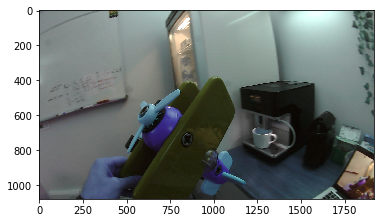

In [306]:
# im = download_image_from_imo(image_dic, out_dir)
plt.imshow(im)
im.dtype

uint8
uint8


True

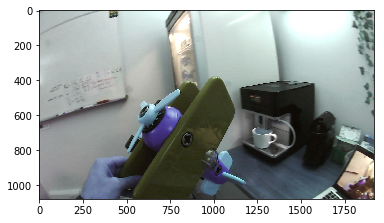

In [311]:
import matplotlib.pyplot as plt
%matplotlib inline

im_p = '/home/blanca/mnt/data/__toy_plane/JPEGImages_1430_A/2_originals_000043.png'
im = cv2.imread(im_p)
print(im.dtype)
plt.imshow(im)

im2 = apply_transform_im(im, 56)

plt.imshow(im2)
print(im2.dtype)

out_dir = '/home/blanca/mnt/data/__toy_plane/JPEGImages_1430_A/'
cv2.imwrite(out_dir + 'test.png', im2)

#### Test Augmentation

In [ ]:
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill_1430_A.json'
with open(anns_file, 'r') as f: anns_dataset = json.load(f)
len(anns_dataset['images']), len(anns_dataset['annotations'])

In [413]:
[io for io in dataset['images'] if io['file_name'] == 'a_10_originals_000054.png']

In [421]:
[ao for ao in dataset['annotations'] if ao['image_id'] == 552]

[{'id': 552,
  'image_id': 552,
  'category_id': [0, 2, 3, 4, 7],
  'segmentation': [[]],
  'area': 33.0,
  'bbox': [1259.0, 302.0, 214.0, 196.0],
  'iscrowd': 0,
  'angle': None}]

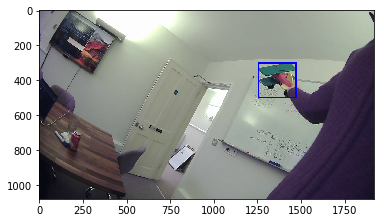

In [424]:
import matplotlib.pyplot as plt
%matplotlib inline

test_ao = [ao for ao in dataset['annotations'] if ao['image_id'] == 552][0]
test_imo = [io for io in dataset['images'] if io['file_name'] == 'a_10_originals_000054.png'][0]

iid, url = test_imo['id'], test_imo['coco_url']
im = np.asarray(bytearray(urllib.request.urlopen(url).read())) #, dtype=np.uint8)
im = cv2.imdecode(im, -1)
        
im_name = test_imo['file_name'] # .split('.png')[0] + '.jpg'
cv2.imwrite(im_name, im)
im = cv2.imread(im_name)

bbox = [int(i) for i in test_ao['bbox']]
x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 5)

plt.imshow(im[:,:,::-1])

In [ ]:
# move to utils
import xmltodict
from skimage import io
from pathlib import Path
import urllib

def download_images_from_url_json(annotations_json_path, output_path, save_images=True): 
    
    with open(annotations_json_path, 'r') as f: anns_dataset = json.load(f)
    not_saved = 0
    for imo in anns_dataset['images']:
        iid, url = imo['id'], imo['coco_url']
        try: im = np.asarray(bytearray(urllib.request.urlopen(url).read())) #, dtype=np.uint8)
        except: 
            not_saved +=1; 
            continue
        im = cv2.imdecode(im, -1)
        
        im_name = imo['file_name'] # .split('.png')[0] + '.jpg'
        if save_images: cv2.imwrite(output_path + im_name, im)
    
    print(not_saved)
    print('Total images: %s  |  Total saved images: %s ' %(len(anns_dataset['images']), len(list(Path(output_path).glob('*.png')))))
        
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill_1430.json'
output_path = '/home/blanca/mnt/data/__toy_plane/JPEGImages_1430/'
im = download_images_from_url_json(anns_file, output_path)

In [ ]:
# # move to utils
# import xmltodict
# from skimage import io
# from pathlib import Path
# import urllib

# def download_images_from_url_json(annotations_json_path, output_path, save_images=True): 
    
#     with open(annotations_json_path, 'r') as f: anns_dataset = json.load(f)
    
#     for imo in anns_dataset['images']:
#         iid, url = imo['id'], imo['coco_url']        
#         im = np.asarray(bytearray(urllib.request.urlopen(url).read()), dtype=np.uint8)
#         im = cv2.imdecode(im, -1)
#         im_name = imo['file_name']
#         if save_images: cv2.imwrite(output_path + im_name, im)

#     print('Total images: %s  |  Total saved images: %s ' %(len(anns_dataset['images']), len(list(Path(output_path).glob('*.png')))))
        
# anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations_attbs_body_drill.json'
# output_path = '/home/blanca/mnt/data/__toy_plane/JPEGImages/'
# im = download_images_from_url_json(anns_file, output_path)

#### check

In [484]:
anns_file = '/home/blanca/mnt/data/__toy_plane/annotations/annotations.json'
with open(anns_file, 'r') as f: anns_dataset = json.load(f)
len(anns_dataset['images']), len(anns_dataset['annotations'])


(1091, 5690)

#### validation set

In [346]:
xml_annotations_folder_path = '__toy_plane/Annotations_folders'
xml_annotations_folder_path = Path(xml_annotations_folder_path)

ann_files = []
for xml_annotations_path in xml_annotations_folder_path.glob('*'):
    if xml_annotations_path.name in ['annotations_13']:
#         print(len(list(xml_annotations_path.glob("*.xml"))))
        folder_files = np.array(list(xml_annotations_path.glob("*.xml")))
        ann_files.append(folder_files)

ann_files = np.concatenate(ann_files, axis=0)
len(ann_files)

243

In [351]:
out_dir = '/home/blanca/mnt/data/__toy_plane/validation_sets/annotations_13/'
dataset = save_image_from_xml(ann_files, out_dir)

TypeError: 'NoneType' object is not subscriptable

In [352]:
def save_image_from_xml(ann_files, out_dir):

    assert len(ann_files) > 0
    
    for file in ann_files:
        
        with open(str(file)) as fd:
            try: doc = xmltodict.parse(fd.read())
            except: print(file); continue
            
            # creating an image: 
            data = doc['annotation']
            # image
            folder = data['folder']
            filename = data['filename']        
            session_type = folder.split('/')[-2]
            session = folder.split('/')[-1]
            im_name = '{:06d}'.format(int(filename.split('.png')[0]))
            im_name = '%s_%s_%s.png' %(session_type, session, im_name)
            if not default_attbs: 
                if im_name.split('.png')[0] in screened_images_names:
                    pre = task[:4]
                    im_name = pre + '_' + im_name  
                else: continue
                
            url = folder + '/' + filename
            
            image_dic = {
                "file_name" : im_name, #str, 
                "coco_url" : url, #str, 
            }
            
            download_image_from_imo(image_dic, out_dir)
            
    print('Total images: %s  |  Total saved images: %s ' %(len(anns_files), len(list(Path(output_dir).glob('*.png')))))

## Create Video

In [478]:
import cv2
import os
import numpy as np

folder = 'test_toy_plane_0' #'test_val_9009_temp_10'

input_dir = '/home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/' + folder + '/'
output_dir = '/home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/'
output_name = output_dir + folder + '.avi'

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".png")])

# print(os.path.join(input_dir, images[0]))
frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 3.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

In [480]:
!ffmpeg -i /home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/test_toy_plane_0.avi /home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorch/Outputs/test_toy_plane_0.mp4 

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.2.0 (crosstool-NG fa8859cb)
  configuration: --prefix=/root/miniconda3 --cc=/opt/conda/conda-bld/ffmpeg_1531088893642/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, avi, from '/home/blanca/mnt/projects/maskrcnn/mask-rcnn.pytorc

## Split Video

In [370]:
def load_video_frames(input_file, output_dir=None, save=False):
    input_file = Path(input_file)
    
    if save:
        assert output_dir is not None
        output_dir = Path(output_dir) / input_file.name.split('.')[0]
        if not os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)
        print('output dir: ', output_dir)
    
    frames = []
    
    count = 0
    vidcap = cv2.VideoCapture(str(input_file))
    # set the fps here
    success, im = vidcap.read()
    while success:
        count += 1
        frames.append(im)
        if save:
            width = 10
            im_name = str(count).zfill(width) + '.jpg'
            cv2.imwrite(str(output_dir / Path(im_name)), im)     # save frame as JPEG file      
#             print('Wrote a new frame as: ', str(output_dir / Path(im_name)))
        
#         if count == 10: break
        success, im = vidcap.read()
        
    return np.array(frames)

idir = '/home/blanca/mnt/recordings/toy_plane/toy_plane_2.avi'
odir = '/home/blanca/mnt/recordings/'
frames = load_video_frames(idir, odir, save=True)

output dir:  /home/blanca/mnt/recordings/toy_plane_2
